### Capstone Project - The Battle of Neighborhoods

# Site Selection Study for Residential Development Project in Chennai, India

Author: Amal Putti
Date: March 2020

### 1. INTRODUCTION

VOQUE CONSTRUCTIONS is one of Asia's largest real estate companies.
Headquartered and listed in Singapore, it is an owner and manager of a global
portfolio comprising integrated developments, shopping malls, lodging, offices,
homes, real estate investment trusts (REITs) and funds. Present across more than 60
cities in over 10 countries, the Group focuses on Singapore and China as core markets
while it continues to expand in markets such as Indonesia and Vietnam.

Voque is determined to foray into the Indian market and are considering in developing
a multistory apartment project in Chennai. Chennai is the fourth largest metropolitan
city of India. It is both the commercial and cultural capital city of the south-eastern
state of Tamil Nadu. The city is developing rapidly and has become a fast-growing city
in India. Currently there are many major industries in the field like automobile,
Hardware manufacture, technology, health and education. It is ranked as a second
major exporter of IT and is also well-known as the automobile capital of India.

<img src="https://www.cbre.com/-/media/images/research-reports/apac/2016/2016-chennai-city_infographic.jpg?la=en">

Since this is Voque’s first project in the country, and being unfamiliar with the local
market of Chennai city, I will be performing a study to:
1. Identify neighborhoods in the city which have a low density of residences, as they consider these areas as ideal for their projects.
2. Classify these neighborhoods based on the average price per square feet(Price PSQFT) into:
    * Low Budget Market
    * Premium Market
    * Luxury Market   
3. Provide a list of the inventory of residential apartments currently available for sale in these neighborhoods and include their features such as:
    * Price
    * Floor Size
    * No. of Bedrooms
    * No. of Bathrooms
    * Furnishing Status (Unfurnished/Semi Furnished/Furnished)
    * Property Condition (Resale or New Property)


### 2. EXTRACTING DATA & CLEANING DATA

Data used in this report was collected primarily from two sources – a leading Indian online real estate property listing website (Magicbricks) and a location data platform (Foursquare)

### Scraping Magicbricks website:
The Magicbricks website gave us all the relevant information on the apartments that are currently for sale in Chennai. Data was scraped using Python libraries to extract the following information:

   * Neighbourhood
   * Neighbourhood Coordinates – Latitude and Longitude of each neighborhood
   * Listing Information – Price, Floor Size, No of Bedrooms and Bathrooms,Furnishing Status, Property Condition and Developer Information (where applicable)
   * Price per square feet (Price PSQFT) – This Price per square feet was not directly available and was indirectly computed using the Price and Floor Size details from the Listing Information.

In [72]:
# Importing the required libraries

import lxml
import re
import numpy as np
import pandas as pd
import math
import requests
import seaborn as sns
from time import sleep
from random import randint
from time import time
from IPython.core.display import clear_output
from bs4 import BeautifulSoup
from requests import get

In [2]:
# Scraping the Magicbricks webpages for the Listing information

# Lists to store data

Locality = []
Price = []
Bedrooms = []
Bathrooms = []
FloorSize = []
SizeType = []
Furnishing = []
Developer = []
Society = []
Type = []
PropType = []
URL = []
Longitude = []
Latitude = []


# Preparing to start monitoring loop
start_time = time()
requests = 0


# Calculating Page Count
response = get('https://www.magicbricks.com/property-for-sale/residential-real-estate?&proptype=Multistorey-Apartment,Builder-Floor-Apartment,Penthouse,Studio-Apartment&cityName=West-area-Chennai&mbTrackSrc=tabChange&page=1&category=S')
html_soup = BeautifulSoup(response.text, 'html.parser')
listing_countFrame = html_soup.find_all("a", class_='active')
listing_countx = listing_countFrame[0].find("span", itemprop="name")
listing_countvalue = str(listing_countx.text)
listing_count_replace1 = listing_countvalue.replace('(', '')
listing_count = int(listing_count_replace1.replace(')', ''))
page_count = math.ceil(listing_count/30)

#Looping through the pages
pages = [str(i) for i in range(1,page_count+1)]
for page in pages:
    
        # Fetching the webpage
        response = get('https://www.magicbricks.com/property-for-sale/residential-real-estate?&proptype=Multistorey-Apartment,Builder-Floor-Apartment,Penthouse,Studio-Apartment&cityName=West-area-Chennai&mbTrackSrc=tabChange&page=' + page + '&category=S')

        # Parse the webpage
        html_soup = BeautifulSoup(response.text, 'html.parser')

        # Add Delay
        sleep(randint(8,15))
       
        # Monitor the requests
        requests += 1
        elapsed_time = time() - start_time
        print('Total Number of Listings:{}'.format(listing_count))
        print('Total Number of Pages: {}'.format(page_count))
        print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
        clear_output(wait = True)

        # Throw a warning for non-200 status codes
        if response.status_code != 200:
            warn('Request: {}; Status code: {}'.format(requests, response.status_code))

        # Break the loop if the number of requests is greater than expected
        if requests > page_count:
            warn('Number of requests was greater than expected.')
            break
        
        # Getting the Locality Details
        ListingLocalityFrame = html_soup.find_all("meta", itemprop="addressLocality")
        
        # Getting the Listing Floor Size
        ListingFloorSizeFrame = html_soup.find_all("div" , class_="m-srp-card__summary js-collapse__content")
        
        # Getting the core details
        ListingFrameMain = html_soup.find_all("span", {'data-categoryidsori':'b'})
        
        # Getting the URL
        ListingUrlFrame = html_soup.find_all("span" , class_="domcache js-domcache-srpgtm")

        # Getting co-ordinates
        LocationFrame = html_soup.find_all("div", itemtype="//schema.org/Apartment")
        
        # Getting Floor Size Type
        SizeTypeFrame= html_soup.find_all("div", class_='m-srp-card__collapse js-collapse')

        
        # Entering data into Dataframe
        
        for listing in ListingFrameMain:
            Price.append(listing['data-price'])
            Bedrooms.append(listing['data-bedroom'])
            Bathrooms.append(listing['data-bathroom'])
            Developer.append(listing['data-devname'])
            Society.append(listing['data-projectname'])
            Type.append(listing['data-transactiontype'])
            PropType.append(listing['data-propertyval'])
    
        for floorsize in ListingFloorSizeFrame:
            FloorSizeSubFrame = floorsize.find("input" , {'type':'hidden'})
            if floorsize.find("input" , {'type':'hidden'}):
                FloorSizeMainFrame = FloorSizeSubFrame['value']
                FloorSize.append(FloorSizeMainFrame)
            else:
                FloorSize.append(0)
    
        for sizetype in SizeTypeFrame:
            
            if sizetype.find("div").text =='\n':
                 SizeType.append("")
                
            else:
                SizeTypeSub = sizetype.find("div", class_='m-srp-card__summary__title').text
                SizeType.append(SizeTypeSub)
            
            #FurnishingCheck = sizetype.find_all("div", class_='m-srp-card__summary__title')
            FurnishingFrame = sizetype.find_all("div", class_='m-srp-card__summary__info')
            if 'furnishing' in sizetype.text:
            
                if 'floor' in sizetype.text:
                    FurnishingSub = FurnishingFrame[4].text
                    Furnishing.append(FurnishingSub)
                
                else:
                    FurnishingSub = FurnishingFrame[3].text
                    Furnishing.append(FurnishingSub)
            
            else:
                Furnishing.append('Unfurnished')
                
        for locality in ListingLocalityFrame:
            Locality.append(locality['content'])
            
        
        for url in ListingUrlFrame:
            URL.append(url['data-detailurl'])
            
        for longitude in LocationFrame:
            LongitudeFrame = longitude.find("meta", itemprop="longitude")
            if longitude.find("meta", itemprop="longitude"):
                LongitudeMainFrame = LongitudeFrame['content']
                Longitude.append(LongitudeMainFrame)
            else:
                Longitude.append(0)
                
        for latitude in LocationFrame:
            LatitudeFrame = latitude.find("meta", itemprop="latitude")
            if latitude.find("meta", itemprop="latitude"):
                LatitudeMainFrame = LatitudeFrame['content']
                Latitude.append(LatitudeMainFrame)
            else:
                Latitude.append(0)

Total Number of Listings:1800
Total Number of Pages: 60
Request:1; Frequency: 0.08019291096337361 requests/s


#### Data has been scraped. Now, lets put the data in a DataFrame. 

In [4]:
# Placing the scraped data in a DataFrame

listing_info_raw = pd.DataFrame({ 
'Property_Type': PropType,
'Locality': Locality,
'Price': Price,
'FloorSize': FloorSize,
'SizeType' : SizeType,
'Bedrooms': Bedrooms,
'Bathrooms': Bathrooms,
'Furnishing' : Furnishing,
'Property_Condition': Type,
'Developer': Developer,
'Society': Society,
'Longitude': Longitude,
'Latitude': Latitude,
'URL': URL
})


# Removing Duplicates and placing in new DataFrame
listing_info = listing_info_raw.drop_duplicates(subset=['FloorSize', 'Price', 'Developer', 'Property_Condition'])

#listing_info = listing_info_raw

# Displays all rows and coloumns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', None)


# Convert Data to appropriate types
listing_info.loc[:, 'FloorSize'] = listing_info['FloorSize'].str[0:4]
listing_info.loc[:, 'Bedrooms'] = listing_info['Bedrooms'].str[-2:1]
listing_info.loc[:, 'Bathrooms'] = listing_info['Bathrooms'].str[-2:1]
listing_info[["Price", "Bedrooms", "Bathrooms", "Longitude", "Latitude", "FloorSize"]] = listing_info[["Price", "Bedrooms", "Bathrooms", "Longitude", "Latitude", "FloorSize"]].apply(pd.to_numeric, errors='coerce')
#listing_info[["Price"]] = pd.Series(listing_info['Price'], dtype='Int64')
#listing_info[["Bedrooms"]] = pd.Series(listing_info['Bedrooms'], dtype='Int64')
#listing_info[["Bathrooms"]] = pd.Series(listing_info['Bathrooms'], dtype='Int64')
#listing_info[["FloorSize"]] = pd.Series(listing_info['FloorSize'], dtype='Int64')
#pd.to_numeric(listings_info['Floor_Size_(sqft)'], downcast ='signed') 

# Computing Price Per SQFT
listing_info["Price_PSQFT"] = np.where(listing_info["SizeType"]=='super area', listing_info.apply(lambda row: row.Price / row.FloorSize, axis=1), listing_info.apply(lambda row: row.Price / (1.32*row.FloorSize), axis=1))               
listing_info[["Price_PSQFT"]] = listing_info[["Price_PSQFT"]].apply(pd.to_numeric, errors='coerce')


# Make the URL clickable
def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val, val)
#listing = listing_info.style.format({'URL': make_clickable})

# Add Nulls to Missing Data and converting few columns to integers
#listing_clean = listing_info.fillna(" ")
listing_info[["Price"]] = pd.Series(listing_info['Price'], dtype='Int64')
listing_info[["Bedrooms"]] = pd.Series(listing_info['Bedrooms'], dtype='Int64')
listing_info[["Bathrooms"]] = pd.Series(listing_info['Bathrooms'], dtype='Int64')
listing_info[["FloorSize"]] = pd.Series(listing_info['FloorSize'], dtype='Int64')

listing_info.head()

,Property_Type,Locality,Price,FloorSize,SizeType,Bedrooms,Bathrooms,Furnishing,Property_Condition,Developer,Society,Longitude,Latitude,URL,Price_PSQFT
0,Apartment,"Kattupakkam, PH Road",4045470,943,super area,2,2,\nVatsa Phase III\n,New Property,StepsStone Promoters Pvt. Ltd.,Vatsa Phase III,0.000000,0.000000,https://www.magicbricks.com/propertyDetails/2-...,4290.000000
1,Apartment,"Kattupakkam, PH Road",4122690,961,super area,2,2,\nVatsa Phase III\n,New Property,StepsStone Promoters Pvt. Ltd.,Vatsa Phase III,0.000000,0.000000,https://www.magicbricks.com/propertyDetails/2-...,4290.000000
2,Apartment,Thiruverkkadu,5706573,1427,super area,3,3,\nVGN Temple Town\n,New Property,VGN Projects Estates Private Limited.,VGN Temple Town,13.070180,80.121750,https://www.magicbricks.com/propertyDetails/3-...,3999.000000
3,Apartment,Thirumazhisai,1819329,506,super area,1,1,Unfurnished,New Property,Vijay Raja Homes Pvt. Ltd.,Vijay Raja Ideal Homes,13.090519,79.999555,https://www.magicbricks.com/propertyDetails/1-...,3595.511858
4,Apartment,Manapakkam,3212000,584,super area,1,2,Unfurnished,New Property,Casagrand Builder Pvt. Ltd.,Casagrand Primera,13.015905,80.167826,https://www.magicbricks.com/propertyDetails/1-...,5500.000000


#### Cleaning the Data and Saving to a CSV File

In [ ]:
# Cleaning the Data
allowed_furnishings = ['Unfurnished','Semi-Furnished','Furnished' ]
allowed_sizetype = ['super area','carpet area' ]
allowed_propcondition = ['New Property','Resale']
listing_info.loc[~listing_info["Furnishing"].isin(allowed_furnishings), "Furnishing"] = "Unfurnished"
listing_info.loc[~listing_info["SizeType"].isin(allowed_sizetype), "SizeType"] = "super area"
listing_info.loc[~listing_info["Property_Condition"].isin(allowed_propcondition), "Property_Condition"] = ""

# Set Index Column
listing_info["ListingID"] = listing_info.index 

listing_cleaned = listing_info[['ListingID','Property_Type', 'Locality','Price','FloorSize','SizeType','Bedrooms','Bathrooms','Furnishing','Property_Condition','Developer','Society','Longitude','Latitude','Price_PSQFT','URL']]
listings_clean = listing_cleaned.dropna()

# Save as CSV
listings_clean.to_csv('Chennai_Listings.csv', header=True)


#### Importing the Saved Data from .csv file

In [381]:
data = pd.read_csv("/Users/aputti/Python Project/Data/Chennai_Listings.csv")
data.head()

,ListingID,Property_Type,Region,Locality,Price,FloorSize,SizeType,Bedrooms,Bathrooms,Furnishing,Property_Condition,Developer,Society,Longitude,Latitude,Price_PSQFT,URL
0,1532,Apartment,Chennai South,Sir Thyagaraya Road,103600000,3810.0,super area,4.0,5.0,Semi-Furnished,Resale,NaN,NaN,0.000000,0.000000,27191.60105,https://www.magicbricks.com/propertyDetails/4-...
1,460,Apartment,Chennai South,Madras Boat Club Road,70000000,2200.0,carpet area,3.0,4.0,Semi-Furnished,New Property,NaN,NaN,13.025351,80.250580,24104.68320,https://www.magicbricks.com/propertyDetails/3-...
2,1991,Builder Floor Apartment,Chennai South,Adyar,61000000,2786.0,super area,4.0,3.0,Furnished,Resale,NaN,NaN,12.999528,80.259575,21895.19024,https://www.magicbricks.com/propertyDetails/4-...
3,1147,Apartment,Chennai South,Besant Nagar,29000000,1675.0,super area,3.0,3.0,Unfurnished,New Property,NaN,NaN,0.000000,0.000000,17313.43284,https://www.magicbricks.com/propertyDetails/3-...
4,388,Builder Floor Apartment,Chennai South,Besant Nagar,24900000,1450.0,super area,3.0,3.0,Unfurnished,Resale,NaN,NaN,12.999589,80.265629,17172.41379,https://www.magicbricks.com/propertyDetails/3-...


#### Creating a new DataFrame with just the neighbourhood, it's Price(per sq. ft.) and it's coordinates. Dropping all other coloumns

In [22]:
temp1 = data[['Locality', 'Price_PSQFT', 'Longitude', 'Latitude' ]].copy()
temp1 = temp1.rename(columns={'Longitude': 'Latitude','Latitude':'Longitude'})
temp =temp1[temp1['Longitude'] !=0]
temp = temp.groupby('Locality').filter(lambda group: group.size > 14)
chennai = temp.groupby(['Locality'])['Price_PSQFT','Latitude', 'Longitude'].median().reset_index()
chennai

,Locality,Price_PSQFT,Latitude,Longitude
0,Abiramapuram,9282.000000,13.031990,80.258896
1,Adambakkam,6412.162261,12.989216,80.202051
2,Adyar,13258.000000,13.003388,80.257289
3,Alandur,5265.483234,13.000546,80.199760
4,Alwarpet,13649.000000,13.035668,80.250031
5,Alwarthirunagar,6557.296534,13.043975,80.183716
6,Ambattur,4077.579508,13.083122,80.160945
7,Aminjikarai,7024.000000,13.071355,80.226942
8,Anakaputhur,3232.323232,12.977826,80.127621
9,Ashok Nagar,10560.146920,13.036874,80.211647


### Create a map of Chennai City with neighborhoods superimposed on top

In [67]:
import folium
from geopy.geocoders import Nominatim

address = 'Sholinganallur,IN'# Shollinganallur is used to center the map since the City limits are skewed south

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Sholinganallur, Chennai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Tambaram, Chennai are 12.9174426, 80.21649018230858.


In [68]:
# create map of Chennai using latitude and longitude values
map_chennai = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, locality, price in zip(chennai['Latitude'], chennai['Longitude'], chennai['Locality'], chennai['Price_PSQFT']):
    label = '{}, {}'.format(locality, price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chennai)  
    
map_chennai

### Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

Foursquare Places API’s are leveraged through their Developer Platform to download Neighbourhood Attributes.

In [39]:
# Foursquare Credentials

CLIENT_ID = 'WODQLCTMQHDQHFYJYLSB2LSVJUKDPAZEAB3WA2F1KSB3T3U5'
CLIENT_SECRET = 'LBUJWF4P2HYOXGLFXCAHVJZXJYTQ2YH12H2B4Z1F5C15ULUU' 
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WODQLCTMQHDQHFYJYLSB2LSVJUKDPAZEAB3WA2F1KSB3T3U5
CLIENT_SECRET:LBUJWF4P2HYOXGLFXCAHVJZXJYTQ2YH12H2B4Z1F5C15ULUU


In [43]:
#Extracting Neighbourhood Attributes (categories)

url_categories = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(url_categories).json()

### Let's print the categories obtained from Foursquare

In [44]:
categories_list = []

# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


Now we use ***explore*** option with **categoryId** to query the number of venues of each category in a specific radius. The response contains a totalResults value for the specified coordinates, radius and category.

In [ ]:

def get_venues_count(lat,long, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                lat,
                long,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']


#Create new dataframe to store venues data
df_venues = chennai.copy()
for c in categories_list:
    df_venues[c[0]] = 0
    
for i, row in df_venues.iterrows():
    for c in categories_list:        
        df_venues.loc[i, c[0]] = get_venues_count(df_venues.Latitude.iloc[i], df_venues.Longitude.iloc[i], radius=1000, categoryId=c[1])

    print(i)
    df_venues.to_csv('Neighbourhood_attributes.csv')   

### 3. ANALYZE EACH NEIGHBORHOOD

In [383]:
df_venues.head()

,Locality,Price_PSQFT,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Abiramapuram,9282.000000,13.031990,80.258896,3,2,0,65,4,6,19,3,29,9
1,Adambakkam,6412.162261,12.989216,80.202051,1,2,0,7,3,6,7,3,4,3
2,Adyar,13258.000000,13.003388,80.257289,4,7,0,68,9,6,14,2,35,4
3,Alandur,5265.483234,13.000546,80.199760,4,5,1,15,3,5,6,2,3,7
4,Alwarpet,13649.000000,13.035668,80.250031,5,7,0,69,10,6,15,1,31,10


***Now that the data is extracted using Foursquare, we have the Neighbourhood attributes (categories) for each Neighbourhood and the count of the number of venues that fall in those categories. This can also be interpreted as the density of occurence of a given category in a particular Neighborhood***

Now we Normalize the data by applying the MinMaxScaler. In this approach, the data is scaled to a fixed range 0 to 1.

In [57]:
from sklearn.preprocessing import MinMaxScaler

X = df_venues.values[:,4:]
scaled_dataset = MinMaxScaler().fit_transform(X)

In [58]:
df_scaled = pd.DataFrame(scaled_dataset)
df_scaled.columns = [c[0] for c in categories_list]
df_scaled.head()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.157895,0.083333,0.000000,0.928571,0.307692,0.428571,0.904762,0.500000,0.617021,0.5625
1,0.052632,0.083333,0.000000,0.100000,0.230769,0.428571,0.333333,0.500000,0.085106,0.1875
2,0.210526,0.291667,0.000000,0.971429,0.692308,0.428571,0.666667,0.333333,0.744681,0.2500
3,0.210526,0.208333,0.333333,0.214286,0.230769,0.357143,0.285714,0.333333,0.063830,0.4375
4,0.263158,0.291667,0.000000,0.985714,0.769231,0.428571,0.714286,0.166667,0.659574,0.6250


### 4. CLUSTER AND CLASSIFY NEIGHBOURHOODS

We use k-means clustering to cluster the neighbourhoods according to the neighbourhood attributes extracted from Foursquare

In [62]:
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt  

# Finding the best value of k

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(df_scaled) 
    kmeanModel.fit(df_scaled)     
 
    distortions.append(sum(np.min(cdist(df_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / df_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(df_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / df_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

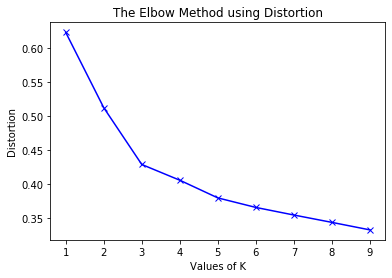

In [69]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

From the "Elbow method" we see the best value of k as 3. This clusters the neighbourhoods in the city into 
 * City Center 
 * City Suburbs 
 * City Outskirts. 

However, we found that increasing the value of k to 4, further splits the City Suburbs into Neighbourhoods with established infrastructure  and New Neighbourhoods with developing infrastructure. This is ideal for our study as typically New Neighbourhoods is where people prefer to invest in as the costs are lower but they still have advantage of the new infrastructure being developed.

For our study further, we use the value **k=4**

In [250]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_scaled)

kmeans_labels = kmeans.labels_

df_venues_clustered = df_venues.copy()
df_venues_clustered['Cluster'] = kmeans_labels

#dataframe to be used for plotting
df_scaled_clustered = df_scaled.copy()
df_scaled_clustered['Cluster'] = kmeans_labels

#### Let's Visualize and Map the Clusters

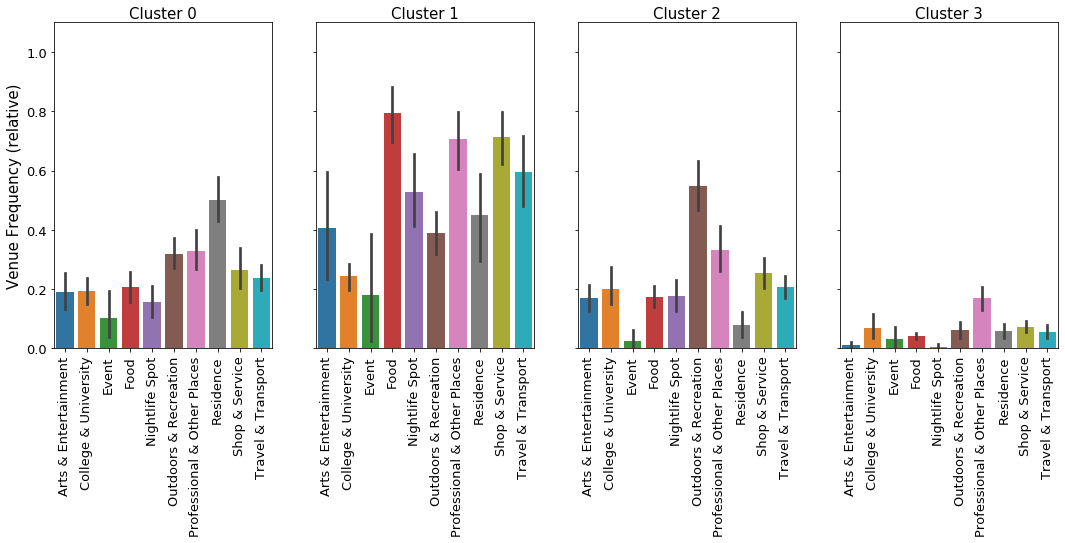

In [73]:
fig,axes= plt.subplots(1,kclusters,figsize=(18,6),sharey=True)

axes[0].set_ylabel('Venue Frequency (relative)', fontsize=15)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(0, kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=15)
    axes[k].tick_params(labelsize=13)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.barplot(data = df_scaled_clustered[df_scaled_clustered['Cluster'] == k].drop('Cluster',1), ax=axes[k])


plt.show()

In [251]:
map_chennai_k = folium.Map(location=[latitude, longitude],zoom_start=11)

#add markers
for i, locality, lat, long, cluster in zip(df_venues_clustered.index,
                                         df_venues_clustered['Locality'],
                                         df_venues_clustered['Latitude'],
                                         df_venues_clustered['Longitude'],
                                         df_venues_clustered['Cluster']):   
    
    colors=['blue','red','magenta','green']
    folium.CircleMarker(
        [lat,long],
        fill=True,
        fill_opacity=1,
        popup=folium.Popup(locality, parse_html=True),
        radius=3,
        color=colors[cluster]
    ).add_to(map_chennai_k)

map_chennai_k 

From the visualization and mapping of the clusters, we can make the following observations:
   * **<font color='blue'>Cluster 0</font>** are well established residential neighborhoods in the City Suburbs
   * **<font color='red'>Cluster 1</font>** are neighborhoods with high denisty of both residential and commercial venues. These, as expected, are located in the centre of the city.
   * **<font color='magenta'>Cluster 2</font>** are neighbourhoods with a low density of residences but have a similar profile as that of some of the more well established residential neighbourhoods.
   * **<font color='green'>Cluster 3</font>** are neighbourhoods in the outskirts of the city with a low density of both commercial and residential areas. 
   
#### From these observations, we have identified that **Cluster 2** fits the client's criteria as it not only enjoys a lower residential density but also has similar neighborhood attributes as those found in more well developed residential areas (Cluster 0) .

In [184]:
# Listing all the 'Neighborhoods' in Cluster 2

chennai['Cluster'] = kmeans_labels
chennai_c2temp = chennai[chennai["Cluster"]==2].reset_index()
chennai_cluster2 = chennai_c2temp.drop(['index','Price Cluster','Cluster'], axis=1)
chennai_cluster2

,Locality,Price_PSQFT,Latitude,Longitude
0,Alwarthirunagar,6557.296534,13.043975,80.183716
1,Ambattur,4077.579508,13.083122,80.160945
2,Anakaputhur,3232.323232,12.977826,80.127621
3,Ashok Nagar,10560.146920,13.036874,80.211647
4,East Coast Road,7241.532977,12.848025,80.240552
5,Karapakkam,5425.973241,12.914312,80.228920
6,Kattankulathur,3230.937934,12.818502,80.040285
7,Keelkattalai,5700.000000,12.958838,80.184647
8,Kottivakkam,12657.828280,12.975598,80.260239
9,Kovilambakkam,5266.903915,12.950176,80.196648


###### The 27 neighbourhoods in Cluster 2 will be now need to be further classified into Low Budget Market, Premium Market & Luxury Market Neighborhoods based on Average Price per sq. ft (Price PSQFT)

In Chennai, the well established classifications of the markets based on Average Prices per sq. ft are:
   * Low Budget Market - INR 2,500 to INR 6,000 per sq. ft
   * Premium Market - INR 6,000 to INR 10,600 per sq. ft
   * Luxury Market - INR 10,600 per sq. ft and above

In [352]:
# Classiying the neighborhoods in Cluster by Average Prices per sq. ft

col         = 'Price_PSQFT'
conditions  = [(chennai_cluster2[col] < 6000) & (chennai_cluster2[col]> 2000), (chennai_cluster2[col] < 10600) & (chennai_cluster2[col]> 6000), (chennai_cluster2[col] > 10600) ]
markets     = [ "Low Budget", 'Premium', 'Luxury' ]

chennai_cluster2["Market"] = np.select(conditions, markets, default=np.nan)

print('Showing the first 5 Neighborhoods')
chennai_cluster2.head()

Showing the first 5 Neighborhoods


,Locality,Price_PSQFT,Latitude,Longitude,Market
0,Alwarthirunagar,6557.296534,13.043975,80.183716,Premium
1,Ambattur,4077.579508,13.083122,80.160945,Low Budget
2,Anakaputhur,3232.323232,12.977826,80.127621,Low Budget
3,Ashok Nagar,10560.146920,13.036874,80.211647,Premium
4,East Coast Road,7241.532977,12.848025,80.240552,Premium


**Let's Visualize these 27 neighbourhoods on a Map**

In [343]:
# Visualizing Cluster 2 Neighbourhood classification based on Price per sq.ft

map_chennai_cluster2 = folium.Map(location=[latitude, longitude],zoom_start=11)

def color(price): 
    if int(price) in range(2000,5999): 
        col = 'green'
    elif int(price) in  range(6000,10599): 
        col = 'blue'
    else: 
        col='red'
    return col 

#add markers
for i, locality, lat, long, price, market in zip(chennai_cluster2.index, 
                                         chennai_cluster2['Locality'],
                                         chennai_cluster2['Latitude'],
                                         chennai_cluster2['Longitude'],
                                         chennai_cluster2['Price_PSQFT'],
                                         chennai_cluster2['Market']):   
    
    folium.CircleMarker(
        [lat,long],
        fill=True,
        fill_opacity=1,
        popup=folium.Popup(market,parse_html=True),
        radius=4,
        color=color(price)
    ).add_to(map_chennai_cluster2)

map_chennai_cluster2 

The neighborhoods are visualized on the maps with the below markers    
   * <font color='red'>Red - </font> **<font color='red'>Luxury Markets</font>**
   * <font color='blue'>Blue -</font> **<font color='blue'>Premium Markets</font>**
   * <font color='green'>Green -</font> **<font color='green'>Low Budget Markets</font>**

**Displaying the number of neighbourhoods by Market Type**

In [378]:
chennai_cluster2temp = pd.DataFrame(chennai_cluster2['Market'].value_counts())
chennai_cluster2count = chennai_cluster2temp.rename(columns={'Market': '# of Neighborhoods'})
chennai_cluster2count

,# of Neighborhoods
Low Budget,16
Premium,9
Luxury,2


**Displaying the neighborhoods in the Premium and Luxury Markets only**

In [367]:
# Filtering the neighborhoods to list only Premium and Luxury Markets

ctemp = chennai_cluster2.loc[chennai_cluster2['Market'] != 'Low Budget']
chennai_grp2 = ctemp.groupby(['Market', 'Locality'])
chennai_grp2 = chennai_grp2.aggregate(np.sum)
chennai_grp2

Price_PSQFT   Latitude  Longitude
Market  Locality                                           
Luxury  Kottivakkam      12657.828280  12.975598  80.260239
        Thiruvanmiyur    10674.157300  12.983258  80.260666
Premium Alwarthirunagar   6557.296534  13.043975  80.183716
        Ashok Nagar      10560.146920  13.036874  80.211647
        East Coast Road   7241.532977  12.848025  80.240552
        Manapakkam        6284.799150  13.016341  80.174619
        Purasawalkam      6487.000000  13.088560  80.250076
        Saidapet          9130.500000  13.020789  80.218315
        Uthandi           7055.181106  12.838152  80.231951
        Virugambakkam     7360.000000  13.055141  80.192688
        West Mambalam     8089.000000  13.038436  80.223373

We have successfully listed all the neighborhoods the client could potentially be interested in and visualized them on a Map. The client can now study these neighborhoods deeper by understanding what kind of apartment inventory is currently being offered in these markets and thier features

#### Obtaining the list of available Apartment inventory listed for sale in Cluster 2 and exporting to .csv

In [384]:
cluster2_list = chennai_cluster2['Locality']
cluster2_listings = data[data['Locality'].isin(cluster2_list)].reset_index(drop=True)

# Save as CSV
cluster2_listings.to_csv('Chennai_Cluster 2_Listings.csv', header=True)

cluster2_listings

,ListingID,Property_Type,Region,Locality,Price,FloorSize,SizeType,Bedrooms,Bathrooms,Furnishing,Property_Condition,Developer,Society,Longitude,Latitude,Price_PSQFT,URL
0,1841,Apartment,Chennai South,Thiruvanmiyur,33500000,2042.0,super area,3.0,3.0,Semi-Furnished,Resale,NaN,NaN,0.000000,0.000000,16405.484820,https://www.magicbricks.com/propertyDetails/3-...
1,1570,Builder Floor Apartment,Chennai South,Thiruvanmiyur,24500000,1510.0,super area,3.0,3.0,Furnished,Resale,NaN,NaN,0.000000,0.000000,16225.165560,https://www.magicbricks.com/propertyDetails/3-...
2,525,Apartment,Chennai South,Thiruvanmiyur,20000000,1248.0,super area,2.0,3.0,Semi-Furnished,Resale,NaN,Seashore Apartments,12.984418,80.267649,16025.641030,https://www.magicbricks.com/propertyDetails/2-...
3,2093,Apartment,Chennai South,Kottivakkam,18000000,1210.0,super area,2.0,2.0,Semi-Furnished,Resale,NaN,NaN,12.975598,80.260239,14876.033060,https://www.magicbricks.com/propertyDetails/2-...
4,34,Apartment,Chennai South,Thiruvanmiyur,21925000,1500.0,super area,3.0,3.0,Unfurnished,New Property,Green Valleys Shelters Pvt. Ltd.,GVSPL Mahameru,0.000000,0.000000,14616.666670,https://www.magicbricks.com/propertyDetails/3-...
5,1166,Apartment,Chennai South,Kottivakkam,48502500,3345.0,super area,4.0,4.0,Unfurnished,New Property,NaN,NaN,0.000000,0.000000,14500.000000,https://www.magicbricks.com/propertyDetails/4-...
6,478,Apartment,Chennai South,Kottivakkam,45000000,2400.0,carpet area,3.0,3.0,Furnished,Resale,NaN,NaN,12.975598,80.260239,14204.545450,https://www.magicbricks.com/propertyDetails/3-...
7,1541,Apartment,Chennai South,Sholinganallur,5200000,284.0,carpet area,1.0,1.0,Unfurnished,Resale,NaN,NaN,12.899978,80.227295,13871.105420,https://www.magicbricks.com/propertyDetails/1-...
8,428,Builder Floor Apartment,Chennai South,Thiruvanmiyur,19000000,1383.0,super area,3.0,3.0,Semi-Furnished,New Property,NaN,NaN,12.986558,80.255531,13738.250180,https://www.magicbricks.com/propertyDetails/3-...
9,618,Apartment,Chennai South,Thiruvanmiyur,47500000,3520.0,super area,5.0,4.0,Semi-Furnished,Resale,NaN,NaN,0.000000,0.000000,13494.318180,https://www.magicbricks.com/propertyDetails/5-...


#### Let's now understand the number of new residential property developments are happening in the Premium and Luxury Markets. This will help us understand if developers are preferring a certain area over others.

In [379]:
cluster2_newlistings = cluster2_listings.loc[(cluster2_listings['Property_Condition'] == 'New Property') & cluster2_listings['Locality'].isin(ctemp['Locality'])]
cluster2_tempcount = pd.DataFrame(cluster2_newlistings['Locality'].value_counts())
cluster2_count = cluster2_tempcount.rename(columns={'Locality': '# of New Residential Developments'})
cluster2_count

,# of New Residential Developments
Thiruvanmiyur,12
Saidapet,9
Uthandi,7
Ashok Nagar,5
West Mambalam,5
Virugambakkam,4
Manapakkam,4
Purasawalkam,3
East Coast Road,2
Alwarthirunagar,2


### 5. RESULTS 

* We started by analyzing 108 Neighborhoods in Chennai City, and we were able to select **27 Neighborhoods** that had a low density of residences and also had similar profile as that of some of the more well-established residential neighborhoods.


* Of these 27 Neighborhoods, we classified them further and identified **9 Premium Markets** and **2 Luxury Markets** which are potential neighborhoods to consider for a multi-story real-estate development. 


* We are also able to provide a list of **893 active listings** of apartments currently for sale along with their attributes for each of these listings in 9 Premium Markets and 2 Luxury Markets. This can be found here.


### 6. DISCUSSION

To further analyze the feasibility and cost benefit analysis of the shortlisted locations, one key data point required is the cost of land. If the cost of land is high, then the developer needs to sell the apartments at a higher price per sq. ft. If this price is significantly higher than the average selling price of the apartments in that neighborhood, the developer may find it difficult to offload his inventory. This study can be further augmented by factoring in this datapoint. The land price data can easily be obtained from magicbricks website.

Another datapoint that would be valuable for this study is the trend of the unsold inventory in these neighborhoods. If the trend shows that unsold inventory has been increasing, it indicates that the supply is exceeding demand and the developer would be competing with other developments. If such is the case, it wouldn’t be advisable to launch a project in these neighborhoods. 


### 7. CONCLUSION

We were able to provide recommendations of potential neighborhoods that meet the client’s requirements. We were also able to give the client an understanding of the pricing in these neighborhoods, how the neighborhood profiles compare with each other, as well as provide an insight to compare other developments that are launched/to be launched in these neighborhoods.

We also recommend expanding this study to include analysis factoring in the cost of land prior to making a decision on the project.
